# Import Dependencies 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
from tqdm import tqdm

from xgboost import plot_importance, XGBRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Data Analysis

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/tough_dataset.csv', encoding='ISO-8859-1')

In [ ]:
data.head()

,id,Target A,Target B,LOAN_AMT,Business Title,Civil Service Title,Division/Work Unit,Job Description,Minimum Qual Requirements,Preferred Skills,Additional Information,To Apply,Hours/Shift,Residency Requirement,Posting Date,Posting Updated,Process Date,FormalEducation,UndergradMajor,CompanySize,DevType,YearsCoding,YearsCodingProf,HopeFiveYears,JobSearchStatus,LastNewJob,UpdateCV,CommunicationTools,TimeFullyProductive,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,HackathonReasons,AgreeDisagree1,AgreeDisagree2,AgreeDisagree3,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,IDE,OperatingSystem,Methodology,VersionControl,CheckInCode,AIDangerous,AIInteresting,AIResponsible,AIFuture,Age,term,emp_length,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,earliest_cr_line,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d
0,68407277,42405.00,0,3600,Account Manager,CONTRACT REVIEWER (OFFICE OF L,Strategy & Analytics,Division of Economic & Financial Opportunity (...,1.\tA baccalaureate degree from an accredited ...,â¢\tExcellent interpersonal and organizationa...,"Salary range for this position is: $42,405 - $...",NaN,NaN,New York City residency is generally required ...,2011-06-24T00:00:00.000,2011-06-24T00:00:00.000,2019-12-17T00:00:00.000,"Bachelors degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,3-5 years,3-5 years,Working as a founder or co-founder of my own c...,"Im not actively looking, but I am open to new...",Less than a year ago,My job status or other personal status changed,Slack,One to three months,"Taught yourself a new language, framework, or ...",The official documentation and/or standards fo...,NaN,To build my professional network,Strongly agree,Strongly agree,Neither Agree nor Disagree,JavaScript;Python;HTML;CSS,JavaScript;Python;HTML;CSS,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,AWS;Azure;Linux;Firebase,AWS;Azure;Linux;Firebase,Django;React,Django;React,Komodo;Vim;Visual Studio Code,Linux-based,Agile;Scrum,Git,Multiple times per day,Artificial intelligence surpassing human intel...,Algorithms making important decisions,The developers or the people creating the AI,I'm excited about the possibilities more than ...,25 - 34 years old,36 months,10+ years,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,190xx,PA,5.91,3-Aug,19-Jan,122.67,NaN,19-Mar
1,68355089,60740.00,1,24700,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",ADMINISTRATIVE BUSINESS PROMOT,Tech Talent Pipeline,The New York City Department of Small Business...,1. A baccalaureate degree from an accredited c...,NaN,NaN,"In addition to applying through this website, ...",NaN,New York City residency is generally required ...,2012-01-26T00:00:00.000,2012-01-26T00:00:00.000,2019-12-17T00:00:00.000,"Bachelors degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,30 or more years,18-20 years,Working in a different or more specialized tec...,I am actively looking for a job,More than 4 years ago,I saw an employers advertisement,Confluence;Office / productivity suite (Micros...,One to three months,"Taught yourself a new language, framework, or ...",The official documentation and/or standards fo...,NaN,NaN,Agree,Agree,Neither Agree nor Disagree,JavaScript;Python;Bash/Shell,Go;Python,Redis;PostgreSQL;Memcached,PostgreSQL,Linux,Linux,Django,React,IPython / Jupyter;Sublime Text;Vim,Linux-based,NaN,Git;Subversion,A few times per week,Increasing automation of jobs,Increasing automation of jobs,The developers or the people creating the AI,I'm excited about the possibilities more than ...,35 - 44 years old,36 months,10+ years,Fully Paid,n,https://lendingclub.com/browse/loanDetai

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2946 entries, 0 to 2945
Data columns (total 69 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         2946 non-null   int64  
 1   Target A                   2946 non-null   float64
 2   Target B                   2946 non-null   int64  
 3   LOAN_AMT                   2946 non-null   int64  
 4   Business Title             2946 non-null   object 
 5   Civil Service Title        2946 non-null   object 
 6   Division/Work Unit         2946 non-null   object 
 7   Job Description            2946 non-null   object 
 8   Minimum Qual Requirements  2926 non-null   object 
 9   Preferred Skills           2553 non-null   object 
 10  Additional Information     1854 non-null   object 
 11  To Apply                   2945 non-null   object 
 12  Hours/Shift                884 non-null    object 
 13  Residency Requirement      2942 non-null   objec

In [ ]:
data = data.apply(lambda x: x.fillna(x.value_counts().index[0]))

In [ ]:
data.head()

,id,Target A,Target B,LOAN_AMT,Business Title,Civil Service Title,Division/Work Unit,Job Description,Minimum Qual Requirements,Preferred Skills,Additional Information,To Apply,Hours/Shift,Residency Requirement,Posting Date,Posting Updated,Process Date,FormalEducation,UndergradMajor,CompanySize,DevType,YearsCoding,YearsCodingProf,HopeFiveYears,JobSearchStatus,LastNewJob,UpdateCV,CommunicationTools,TimeFullyProductive,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,HackathonReasons,AgreeDisagree1,AgreeDisagree2,AgreeDisagree3,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,IDE,OperatingSystem,Methodology,VersionControl,CheckInCode,AIDangerous,AIInteresting,AIResponsible,AIFuture,Age,term,emp_length,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,earliest_cr_line,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d
0,68407277,42405.00,0,3600,Account Manager,CONTRACT REVIEWER (OFFICE OF L,Strategy & Analytics,Division of Economic & Financial Opportunity (...,1.\tA baccalaureate degree from an accredited ...,â¢\tExcellent interpersonal and organizationa...,"Salary range for this position is: $42,405 - $...","Click the ""Apply Now"" button.",35 Hours,New York City residency is generally required ...,2011-06-24T00:00:00.000,2011-06-24T00:00:00.000,2019-12-17T00:00:00.000,"Bachelors degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,3-5 years,3-5 years,Working as a founder or co-founder of my own c...,"Im not actively looking, but I am open to new...",Less than a year ago,My job status or other personal status changed,Slack,One to three months,"Taught yourself a new language, framework, or ...",The official documentation and/or standards fo...,I already had a full-time job as a developer w...,To build my professional network,Strongly agree,Strongly agree,Neither Agree nor Disagree,JavaScript;Python;HTML;CSS,JavaScript;Python;HTML;CSS,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,AWS;Azure;Linux;Firebase,AWS;Azure;Linux;Firebase,Django;React,Django;React,Komodo;Vim;Visual Studio Code,Linux-based,Agile;Scrum,Git,Multiple times per day,Artificial intelligence surpassing human intel...,Algorithms making important decisions,The developers or the people creating the AI,I'm excited about the possibilities more than ...,25 - 34 years old,36 months,10+ years,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,190xx,PA,5.91,3-Aug,19-Jan,122.67,19-Apr,19-Mar
1,68355089,60740.00,1,24700,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",ADMINISTRATIVE BUSINESS PROMOT,Tech Talent Pipeline,The New York City Department of Small Business...,1. A baccalaureate degree from an accredited c...,ERROR: #NAME?,Appointments are subject to OMB approval. For ...,"In addition to applying through this website, ...",35 Hours,New York City residency is generally required ...,2012-01-26T00:00:00.000,2012-01-26T00:00:00.000,2019-12-17T00:00:00.000,"Bachelors degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,30 or more years,18-20 years,Working in a different or more specialized tec...,I am actively looking for a job,More than 4 years ago,I saw an employers advertisement,Confluence;Office / productivity suite (Micros...,One to three months,"Taught yourself a new language, framework, or ...",The official documentation and/or standards fo...,I already had a full-time job as a developer w...,To improve my general technical skills or prog...,Agree,Agree,Neither Agree nor Disagree,JavaScript;Python;Bash/Shell,Go;Python,Redis;PostgreSQL;Memcached,PostgreSQL,Linux,Linux,Django,React,IPython / Jupyter;Sublime Text;Vim,Linux-based,Agile;Scrum,Git;Subversion,A few times per week,I

In [ ]:
print(data.dtypes.astype(str).value_counts())

object     63
int64       3
float64     3
dtype: int64


In [ ]:
data = data.drop(['pymnt_plan','id', 'Target B', 'Process Date', 'next_pymnt_d', 'url'], axis = 1)

#Feature Engineering

## Zip Code

In [ ]:
data['zip_code'] = data['zip_code'].replace('xx','', regex = True)

In [ ]:
data['zip_code'] = pd.to_numeric(data['zip_code'])

In [ ]:
data['zip_code']

0       190
1       577
2       605
3        76
4       174
       ... 
2941    234
2942    207
2943    907
2944    274
2945    606
Name: zip_code, Length: 2946, dtype: int64

## Fixing Date Time Issue

In [ ]:
for (i,j) in zip(data['earliest_cr_line'].values, range(0,len(data['earliest_cr_line']))):
  if i[0].isalpha():
    x = i[0:3:]
    i = i[4::] + '-' + x
  data['earliest_cr_line'][j] = i

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
data[['last_credit_pull_d', 'last_pymnt_d', 'earliest_cr_line']] = data[['last_credit_pull_d', 'last_pymnt_d', 'earliest_cr_line']].replace( {'Jan' : '01', 'Feb' : '02', 'Mar' : '03', 'Apr' : '04', 'May' : '05',
            'Jun' : '06', 'Jul' : '07', 'Aug' : '08', 'Sep' : '09', 'Oct' : '10', 'Nov' : '11', 'Dec' : '12'} , regex= True)

In [ ]:
for (i,j) in zip(data['earliest_cr_line'].values, range(0,len(data['earliest_cr_line']))):
    x = i.find('-')
    if len(i[0:x]) == 1:
      i = '0' + i
    data['earliest_cr_line'][j] = i

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
data['earliest_cr_line']

0       03-08
1       99-12
2       00-08
3       08-09
4       98-06
        ...  
2941    03-01
2942    03-11
2943    99-12
2944    11-09
2945    98-07
Name: earliest_cr_line, Length: 2946, dtype: object

In [ ]:
l = ['last_credit_pull_d', 'last_pymnt_d', 'earliest_cr_line']

for i in l:

  data[i] = pd.to_datetime(data[i], format='%y-%m')

In [ ]:
l = ['Posting Date' , 'Posting Updated']

for i in l :
  data[i] = pd.to_datetime(data[i])

In [ ]:
data[l]

,Posting Date,Posting Updated
0,2011-06-24,2011-06-24
1,2012-01-26,2012-01-26
2,2013-10-24,2013-12-12
3,2013-10-24,2013-12-12
4,2014-01-09,2014-01-08
...,...,...
2941,2019-12-16,2019-12-16
2942,2019-12-16,2019-12-16
2943,2019-12-16,2019-12-16
2944,2019-12-16,2019-12-16


In [ ]:
l = ['last_credit_pull_d',  'last_pymnt_d', 'Posting Date' , 'Posting Updated', 'earliest_cr_line']

for i in l:

  data[i] = data[i].map(dt.datetime.toordinal)

## Label Encoding vs One Hot Encoding

In [ ]:
ohe_columns = []
for i in data.columns:
  if len(pd.unique(data[i])) < 13:
         print("Number of Unique Value in {} : {}".format(i, len(pd.unique(data[i]))))
         ohe_columns.append(i)     

Number of Unique Value in FormalEducation : 9
Number of Unique Value in UndergradMajor : 12
Number of Unique Value in CompanySize : 8
Number of Unique Value in YearsCoding : 11
Number of Unique Value in YearsCodingProf : 11
Number of Unique Value in HopeFiveYears : 7
Number of Unique Value in JobSearchStatus : 3
Number of Unique Value in LastNewJob : 5
Number of Unique Value in UpdateCV : 8
Number of Unique Value in TimeFullyProductive : 6
Number of Unique Value in TimeAfterBootcamp : 8
Number of Unique Value in AgreeDisagree1 : 5
Number of Unique Value in AgreeDisagree2 : 5
Number of Unique Value in AgreeDisagree3 : 5
Number of Unique Value in OperatingSystem : 4
Number of Unique Value in CheckInCode : 6
Number of Unique Value in AIDangerous : 4
Number of Unique Value in AIInteresting : 4
Number of Unique Value in AIResponsible : 4
Number of Unique Value in AIFuture : 3
Number of Unique Value in Age : 6
Number of Unique Value in term : 2
Number of Unique Value in emp_length : 11
Numbe

In [ ]:
dummy = pd.get_dummies(data[ohe_columns])

In [ ]:
data = data.drop(columns=ohe_columns)

In [ ]:
data = pd.concat([data, dummy], axis=1)

In [ ]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

data.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in data.columns.values]

In [ ]:
data.head()

,Target A,LOAN_AMT,Business Title,Civil Service Title,Division/Work Unit,Job Description,Minimum Qual Requirements,Preferred Skills,Additional Information,To Apply,Hours/Shift,Residency Requirement,Posting Date,Posting Updated,DevType,CommunicationTools,EducationTypes,SelfTaughtTypes,HackathonReasons,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,IDE,Methodology,VersionControl,zip_code,addr_state,dti,earliest_cr_line,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,FormalEducation_Associate degree,"FormalEducation_Bachelors degree (BA, BS, B.Eng., etc.)",FormalEducation_I never completed any formal education,...,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length__ 1 year,loan_status_Charged Off,loan_status_Current,loan_status_Fully Paid,loan_status_In Grace Period,loan_status_Late (16-30 days),loan_status_Late (31-120 days),purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,title_Business,title_Car financing,title_Credit card refinancing,title_Debt consolidation,title_Green loan,title_Home buying,title_Home improvement,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation
0,42405.00,3600,Account Manager,CONTRACT REVIEWER (OFFICE OF L,Strategy & Analytics,Division of Economic & Financial Opportunity (...,1.\tA baccalaureate degree from an accredited ...,â¢\tExcellent interpersonal and organizationa...,"Salary range for this position is: $42,405 - $...","Click the ""Apply Now"" button.",35 Hours,New York City residency is generally required ...,734312,734312,Full-stack developer,Slack,"Taught yourself a new language, framework, or ...",The official documentation and/or standards fo...,To build my professional network,JavaScript;Python;HTML;CSS,JavaScript;Python;HTML;CSS,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,AWS;Azure;Linux;Firebase,AWS;Azure;Linux;Firebase,Django;React,Django;React,Komodo;Vim;Visual Studio Code,Agile;Scrum,Git,190,PA,5.91,731428,737060,122.67,737119,0,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,60740.00,24700,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",ADMINISTRATIVE BUSINESS PROMOT,Tech Talent Pipeline,The New York City Department of Small Business...,1. A baccalaureate degree from an accredited c...,ERROR: #NAME?,Appointments are subject to OMB approval. For ...,"In addition to applying through this website, ...",35 Hours,New York City residency is generally required ...,734528,734528,Database administrator;DevOps specialist;Full-...,Confluence;Office / productivity suite (Micros...,"Taught yourself a new language, framework, or ...",The official documentation and/or standards fo...,To improve my general technical skills or prog...,JavaScript;Python;Bash/Shell,Go;Python,Redis;PostgreSQL;Memcached,PostgreSQL,Linux,Linux,Django,React,IPython / Jupyter;Sublime Text;Vim,Agile;Scrum,Git;Subversion,577,SD,16.06,730089,736116,926.35,737119,0,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,51907.68,20000,Maintenance Worker - Technical Services-Heatin...,MAINTENANCE WORKER,Management Services Department,"Under direct supervision, assist in the routin...",1. Three years of full-time satisfactory exper...,1. A High School Diploma or GED. 2. CDL Dri...,1. A Motor Vehicle Driverâs License valid i...,"Click the ""Apply Now"" button.",35 Hours,NYCHA has no residency requirements.,735165,735214,Engineering manager;Full-stack developer,"Office / productivity suite (Microsoft Office,...","Taught yourself a 

## Word Embedding

In [ ]:
text_columns = data.select_dtypes(exclude=['uint8', 'float64', 'int64']).columns

In [ ]:
text_columns

Index(['Business Title', 'Civil Service Title', 'Division/Work Unit',
       'Job Description', 'Minimum Qual Requirements', 'Preferred Skills',
       'Additional Information', 'To Apply', 'Hours/Shift',
       'Residency Requirement', 'DevType', 'CommunicationTools',
       'EducationTypes', 'SelfTaughtTypes', 'HackathonReasons',
       'LanguageWorkedWith', 'LanguageDesireNextYear', 'DatabaseWorkedWith',
       'DatabaseDesireNextYear', 'PlatformWorkedWith',
       'PlatformDesireNextYear', 'FrameworkWorkedWith',
       'FrameworkDesireNextYear', 'IDE', 'Methodology', 'VersionControl',
       'addr_state'],
      dtype='object')

In [ ]:
data['AllText'] = data['Business Title'].str.cat(data[text_columns[1::]], sep=' - ')

In [ ]:
data = data.drop(text_columns, axis = 1)

In [ ]:
data

,Target A,LOAN_AMT,Posting Date,Posting Updated,zip_code,dti,earliest_cr_line,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,FormalEducation_Associate degree,"FormalEducation_Bachelors degree (BA, BS, B.Eng., etc.)",FormalEducation_I never completed any formal education,"FormalEducation_Masters degree (MA, MS, M.Eng., MBA, etc.)","FormalEducation_Other doctoral degree (Ph.D, Ed.D., etc.)",FormalEducation_Primary/elementary school,"FormalEducation_Professional degree (JD, MD, etc.)","FormalEducation_Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",FormalEducation_Some college/university study without earning a degree,"UndergradMajor_A business discipline (ex. accounting, finance, marketing)","UndergradMajor_A health science (ex. nursing, pharmacy, radiology)","UndergradMajor_A humanities discipline (ex. literature, history, philosophy)","UndergradMajor_A natural science (ex. biology, chemistry, physics)","UndergradMajor_A social science (ex. anthropology, psychology, political science)","UndergradMajor_Another engineering discipline (ex. civil, electrical, mechanical)","UndergradMajor_Computer science, computer engineering, or software engineering","UndergradMajor_Fine arts or performing arts (ex. graphic design, music, studio art)",UndergradMajor_I never declared a major,"UndergradMajor_Information systems, information technology, or system administration",UndergradMajor_Mathematics or statistics,UndergradMajor_Web development or web design,"CompanySize_1,000 to 4,999 employees",CompanySize_10 to 19 employees,"CompanySize_10,000 or more employees",CompanySize_100 to 499 employees,CompanySize_20 to 99 employees,"CompanySize_5,000 to 9,999 employees",CompanySize_500 to 999 employees,CompanySize_Fewer than 10 employees,YearsCoding_0-2 years,...,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length__ 1 year,loan_status_Charged Off,loan_status_Current,loan_status_Fully Paid,loan_status_In Grace Period,loan_status_Late (16-30 days),loan_status_Late (31-120 days),purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,title_Business,title_Car financing,title_Credit card refinancing,title_Debt consolidation,title_Green loan,title_Home buying,title_Home improvement,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation,AllText
0,42405.00,3600,734312,734312,190,5.91,731428,737060,122.67,737119,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,Account Manager - CONTRACT REVIEWER (OFFICE OF...
1,60740.00,24700,734528,734528,577,16.06,730089,736116,926.35,737119,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT - ADM..."
2,51907.68,20000,735165,735214,605,10.78,730333,736481,15813.30,737119,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,Maintenance Worker - Technical Services-Heatin...
3,51907.68,35000,735165,735214,76,17.06,733286,737091,829.90,737119,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,Maintenance Worker - Technical Services-Heatin...
4,35.00,10400,735242,735241,174,25.37,729541,736146,10128.96,736754,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Temporary Painter - PAINTER - Dept of Manageme...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
list_of_sentance=[]
for sentance in data['AllText']:
  list_of_sentance.append(sentance.split())

w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)


#w2v_model=KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Colab Notebooks/Datasets/GoogleNews-vectors-negative300.bin', binary=True)


print(w2v_model.wv.most_similar('job'))
print(w2v_model.wv.most_similar('business'))

w2v_words = list(w2v_model.wv.vocab)
print('-'*100)
print("number of words that occured minimum 5 times : ",len(w2v_words))
print("sample words : ", w2v_words[0:50])

[('listed', 0.7580226063728333), ('posting', 0.7188577651977539), ('notice.', 0.6797120571136475), ('growth;', 0.5775238871574402), ('Vacancy', 0.5698394179344177), ('outlined', 0.5290988087654114), ('(d)', 0.5198276042938232), ('notice.â\x80\x9d', 0.5085221529006958), ('notice', 0.5006989240646362), ('notices', 0.4918994903564453)]
[('learning', 0.6536786556243896), ('needs,', 0.6429909467697144), ('validate', 0.5824034810066223), ('analysis,', 0.5768103003501892), ('sales', 0.5758575797080994), ('technical', 0.5711307525634766), ('test', 0.568091094493866), ('utilization', 0.5594037771224976), ('improvements', 0.5568499565124512), ('efficiencies', 0.5563071966171265)]
----------------------------------------------------------------------------------------------------
number of words that occured minimum 5 times :  16390
sample words :  ['Account', 'Manager', '-', 'CONTRACT', 'OF', 'Strategy', '&', 'Analytics', 'Division', 'of', 'Economic', 'Financial', 'Opportunity', '(DEFO)', 'Mayor

In [ ]:
# average Word2Vec
# compute average word2vec for each description.
sent_vectors = []; # the avg-w2v for each sentence/description is stored in this list
for sent in tqdm(list_of_sentance): # for each description/sentence
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/description
    for word in sent: # for each word in a description/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)


100%|██████████| 2946/2946 [02:32<00:00, 19.29it/s]


In [ ]:
arr = np.array(sent_vectors)

In [ ]:
arr.shape

(2946, 50)

In [ ]:
column_name = ['text{}'.format(i) for i in range(1,51)]

In [ ]:
text_frame = pd.DataFrame(arr, columns = column_name)

In [ ]:
text_frame

,text1,text2,text3,text4,text5,text6,text7,text8,text9,text10,text11,text12,text13,text14,text15,text16,text17,text18,text19,text20,text21,text22,text23,text24,text25,text26,text27,text28,text29,text30,text31,text32,text33,text34,text35,text36,text37,text38,text39,text40,text41,text42,text43,text44,text45,text46,text47,text48,text49,text50
0,-0.012012,-0.072682,-0.506300,-0.069007,0.511382,0.506267,-0.670730,-0.218867,-0.220268,-0.084764,0.718509,-0.132134,-0.433422,0.357568,-0.336798,-0.660583,-0.319748,-0.309961,0.056126,1.336108,-0.332359,-0.034758,-0.318775,0.253622,0.218379,-0.533697,0.041732,0.148925,0.639717,0.450816,-0.031326,-0.210619,-0.119458,-0.621858,0.321155,-0.172701,-0.409812,0.648089,0.477872,-0.311376,0.295951,-0.296925,0.487633,-0.296991,-0.881944,0.442122,0.513778,-0.170601,0.022920,-0.540948
1,0.021142,0.271994,-0.696630,-0.097580,0.656568,0.530392,-0.541532,-0.033154,-0.178044,-0.067015,0.716917,-0.297630,-0.364906,0.046459,-0.323068,-0.678793,-0.341441,-0.334414,-0.178070,1.104397,-0.149464,-0.147597,-0.218730,0.000638,0.054630,-0.468690,-0.142122,0.208170,0.612237,0.601747,-0.059174,-0.196585,0.102068,-0.582727,0.299041,-0.156173,-0.559790,0.586921,0.454495,-0.421801,0.409402,-0.292783,0.685529,-0.239929,-0.753928,0.087431,0.356355,-0.065300,-0.055123,-0.533255
2,-0.745274,-0.188993,-0.199658,-0.131104,-0.525577,0.408406,-0.284080,-0.421359,-0.347773,-0.217749,0.502721,-0.506513,-0.006184,0.367617,-0.614525,-0.697282,-0.048567,0.100614,0.104397,0.841684,-0.561115,0.175496,-0.585051,0.127788,0.074561,-0.500797,0.095820,0.305869,0.614340,0.147684,0.044028,-0.456847,-0.254786,-0.631693,-0.104484,-0.199428,-0.732000,0.808965,0.764613,0.120328,-0.288451,-0.180965,0.572588,0.104885,-1.020587,0.559330,0.777968,-0.446380,0.235950,-0.468446
3,-0.680911,-0.145801,-0.183225,-0.135776,-0.482428,0.378671,-0.268201,-0.399838,-0.283455,-0.222766,0.546028,-0.497144,-0.083798,0.336716,-0.633957,-0.674422,-0.036117,0.051030,0.127429,0.870752,-0.531386,0.143216,-0.558807,0.103746,0.078169,-0.459681,0.118735,0.280425,0.568906,0.096125,0.047546,-0.414802,-0.233244,-0.638479,-0.069882,-0.208832,-0.725170,0.776911,0.728560,0.096955,-0.249356,-0.187265,0.506928,0.178599,-0.946955,0.537935,0.741601,-0.448574,0.177619,-0.453914
4,-0.582658,0.552441,0.194323,-0.641805,-0.501297,0.409870,0.360045,-0.193802,0.069476,0.148590,0.291495,-1.042783,-0.078315,0.556906,-0.306425,-0.574097,-0.434391,0.064881,0.361255,0.551595,-0.787118,0.055722,-0.786006,0.287409,0.336799,-0.156428,0.634048,0.451057,0.308847,-0.587697,-0.298011,-0.361488,-0.413304,-0.589926,-0.329504,0.203888,-0.796133,0.834183,0.687558,0.672808,-0.266403,0.391902,0.443228,0.313355,-0.702264,0.622274,0.865552,-0.613993,0.205537,-0.824507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2941,-0.567619,-0.160961,-0.715711,-0.091099,-0.220020,0.645133,-0.488881,-0.652051,-0.296768,-0.266882,0.951099,-0.601604,-0.002996,0.121688,-0.418454,-0.826681,-0.264735,-0.170409,0.040594,1.041614,-0.249833,-0.147059,-0.622616,-0.036347,0.079745,-0.671347,-0.052536,0.218793,0.736194,0.477774,0.113916,-0.391766,0.298456,-0.497248,0.118200,-0.295420,-0.723871,0.733503,0.563980,-0.192357,0.129677,-0.228255,0.713823,-0.214090,-1.054796,0.243289,0.787407,-0.328972,-0.030766,-0.373403
2942,-0.571901,-0.210106,-0.780259,-0.044591,-0.220326,0.609391,-0.561660,-0.614260,-0.365875,-0.261812,0.928443,-0.532199,0.021979,0.092086,-0.431898,-0.803875,-0.264168,-0.117799,-0.051553,1.138356,-0.200367,-0.161787,-0.606825,0.004422,0.089036,-0.728710,-0.125192,0.242080,0.776678,0.584374,0.143115,-0.405774,0.354530,-0.522749,0.080657,-0.318426,-0.729677,0.726519,0.609133,-0.245676,0.061742,-0.282651,0.709664,-0.183666,-1.098821,0.207314,0.758663,-0.287246,-0.006808,-0.317659
2943,-0.187869,-0.001798,-0.768634,0.037167,0.434151,0.641937,-0.715669,-0.143827,

In [ ]:
data = data.drop('AllText', axis=1)

In [ ]:
data = data.join(text_frame)

# Feature Importance

In [ ]:
(data.corr())["Target A"].sort_values(ascending = False)[1:20:]

text33    0.326983
text20    0.305148
text6     0.298273
text11    0.277593
text15    0.250918
text43    0.248261
text17    0.240837
text31    0.228951
text21    0.207092
text27    0.202778
text46    0.195235
text37    0.186990
text5     0.178390
text48    0.173632
text24    0.168766
text19    0.162792
text50    0.111722
text8     0.105227
text29    0.101941
Name: Target A, dtype: float64

In [ ]:
num_columns = data.select_dtypes(exclude=["object"]).columns

In [ ]:
num_columns

Index(['Target A', 'LOAN_AMT', 'Posting Date', 'Posting Updated', 'zip_code',
       'dti', 'earliest_cr_line', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d',
       ...
       'text41', 'text42', 'text43', 'text44', 'text45', 'text46', 'text47',
       'text48', 'text49', 'text50'],
      dtype='object', length=237)

[13:19:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


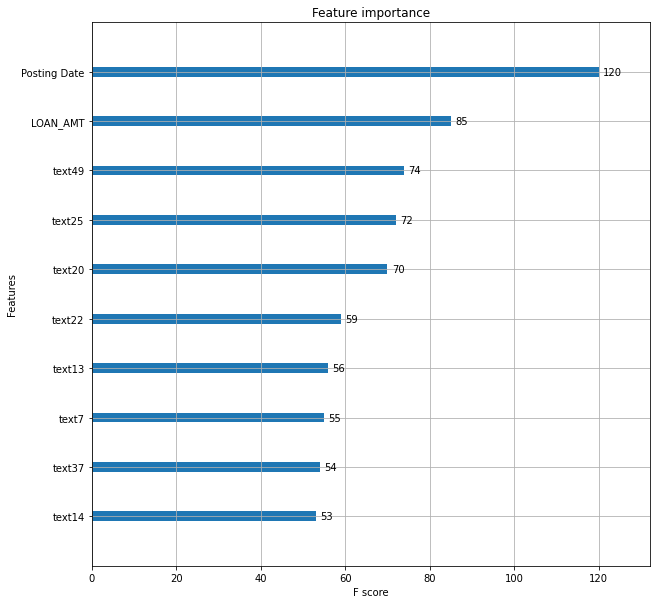

In [ ]:
xgb = XGBRegressor(max_depth = 5, objective= 'reg:linear')
xgb.fit(data[num_columns].drop('Target A', axis = 1), data['Target A'])
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
impplot = plot_importance(xgb, ax = ax, max_num_features=10)
plt.show()

# Training the Model

In [ ]:
x = data.drop(['Target A'], axis = 1)
y = data['Target A']

x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.2)
lr = LinearRegression().fit(x_train,y_train)

y_pred = lr.predict(x_test)

rms = mean_squared_error(y_test, y_pred, squared=False)

print(rms)

23107.512080871613


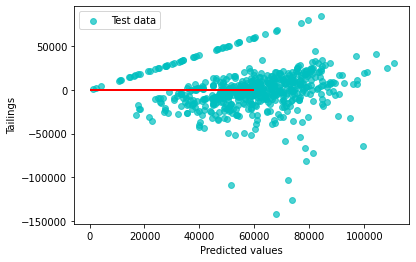

In [ ]:
plt.scatter(y_pred, y_pred - y_test,
          c = 'c', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')

plt.xlabel('Predicted values')
plt.ylabel('Tailings')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 0, xmax = 60000, lw = 2, color = 'red')
plt.show()

In [ ]:
forest = RandomForestRegressor(n_estimators = 100, criterion = 'mse', random_state = 1, n_jobs = -1)

forest.fit(x_train,y_train)
forest_test_pred = forest.predict(x_test)

rms2 = mean_squared_error(y_test,forest_test_pred, squared=False)

print(rms2)

18684.05765851002


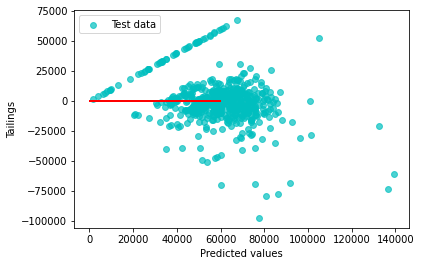

In [ ]:
plt.scatter(forest_test_pred,forest_test_pred - y_test,
          c = 'c', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')

plt.xlabel('Predicted values')
plt.ylabel('Tailings')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 0, xmax = 60000, lw = 2, color = 'red')
plt.show()